In [1]:

import os
import torch
import argparse
import numpy as np
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
import cv2

from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import networks
from utils.transforms import transform_logits
from datasets.simple_extractor_dataset import SimpleFolderDataset

dataset_settings = {
    'lip': {
        'input_size': [473, 473],
        'num_classes': 20,
        'label': ['Background', 'Hat', 'Hair', 'Glove', 'Sunglasses', 'Upper-clothes', 'Dress', 'Coat',
                  'Socks', 'Pants', 'Jumpsuits', 'Scarf', 'Skirt', 'Face', 'Left-arm', 'Right-arm',
                  'Left-leg', 'Right-leg', 'Left-shoe', 'Right-shoe']
    },
    'atr': {
        'input_size': [512, 512],
        'num_classes': 18,
        'label': ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt',
                  'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']
    },
    'pascal': {
        'input_size': [512, 512],
        'num_classes': 7,
        'label': ['Background', 'Head', 'Torso', 'Upper Arms', 'Lower Arms', 'Upper Legs', 'Lower Legs'],
    }
}


def get_arguments():
    """Parse all the arguments provided from the CLI.
    Returns:
      A list of parsed arguments.
    """
    parser = argparse.ArgumentParser(description="Self Correction for Human Parsing")

    parser.add_argument("--dataset", type=str, default='lip', choices=['lip', 'atr', 'pascal'])
    parser.add_argument("--model-restore", type=str, default='exp-schp-201908261155-lip.pth', help="restore pretrained model parameters.")
    parser.add_argument("--gpu", type=str, default='0', help="choose gpu device.")
    parser.add_argument("--input-dir", type=str, default='images', help="path of input image folder.")
    parser.add_argument("--output-dir", type=str, default='images', help="path of output image folder.")
    parser.add_argument("--logits", action='store_true', default=False, help="whether to save the logits.")
    return parser.parse_args()


def get_palette(num_cls):
    """ Returns the color map for visualizing the segmentation mask.
    Args:
        num_cls: Number of classes
    Returns:
        The color map
    """
    n = num_cls
    palette = [0] * (n * 3)
    for j in range(0, n):
        lab = j
        palette[j * 3 + 0] = 0
        palette[j * 3 + 1] = 0
        palette[j * 3 + 2] = 0
        i = 0
        while lab:
            palette[j * 3 + 0] |= (((lab >> 0) & 1) << (7 - i))
            palette[j * 3 + 1] |= (((lab >> 1) & 1) << (7 - i))
            palette[j * 3 + 2] |= (((lab >> 2) & 1) << (7 - i))
            i += 1
            lab >>= 3
    print(palette)
    return palette


In [38]:

def extract(img, comps):
    #args = get_arguments()

    gpus = [0]
    assert len(gpus) == 1
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'

    num_classes = dataset_settings['lip']['num_classes']
    input_size = dataset_settings['lip']['input_size']
    label = dataset_settings["lip"]['label']
    print("Evaluating total class number {} with {}".format(num_classes, label))

    model = networks.init_model('resnet101', num_classes=num_classes, pretrained=None)

    state_dict = torch.load('exp-schp-201908261155-lip.pth')['state_dict']
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:]  # remove `module.`
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    model.cuda()
    model.eval()

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.406, 0.456, 0.485], std=[0.225, 0.224, 0.229])
    ])
    dataset = SimpleFolderDataset(img=img, input_size=input_size, transform=transform)
    #dataloader = DataLoader(dataset)

    palette = get_palette(num_classes)
    with torch.no_grad():
        image, meta = dataset.get_img()
        print(image.shape)
        img_name = meta['name']
        c = meta['center']
        s = meta['scale']
        w = meta['width']
        h = meta['height']
        cuda = image.cuda()
        output = model(cuda)
        #cuda = cuda.cpu()
        #print("c", np.array(output).shape)
        #cudnum = np.transpose(cuda[0].numpy(), (1,2,0))
        #print(cudnum.shape)
        #output_img = Image.fromarray(np.asarray(cudnum, dtype=np.uint8))
        #output_img.putpalette(palette)
        #output_img.save("images/b.png")
        #plt.imshow(np.flip(cudnum, axis=2))

        #print(np.transpose(cuda.numpy()).shape)
        upsample = torch.nn.Upsample(size=input_size, mode='bilinear', align_corners=True)
        upsample_output = upsample(output[0][-1][0].unsqueeze(0))
        upsample_output = upsample_output.squeeze()
        upsample_output = upsample_output.permute(1, 2, 0)  # CHW -> HWC

        logits_result = transform_logits(upsample_output.data.cpu().numpy(), c, s, w, h, input_size=input_size)
        parsing_result = np.argmax(logits_result, axis=2)
        #print(np.unique(parsing_result))

        #print(image.cuda().shape, parsing_result.shape)
        parsing_result_path = os.path.join("images", img_name[:-4] + '.png')
        output_img = Image.fromarray(np.asarray(parsing_result, dtype=np.uint8))
        output_img.putpalette(palette)
        output_img.save("images/b.png")
        label=np.array(label)
        comp_ind = np.where(np.isin(label, comps) )
        return np.where(np.isin(parsing_result, comp_ind))
        #mask = np.zeros(parsing_result.shape[0])
        #plt.imshow(parsing_result)
        #if args.logits:
        #    logits_result_path = os.path.join("images", img_name[:-4] + '.npy')
        #    np.save(logits_result_path, logits_result)
    return


Evaluating total class number 20 with ['Background', 'Hat', 'Hair', 'Glove', 'Sunglasses', 'Upper-clothes', 'Dress', 'Coat', 'Socks', 'Pants', 'Jumpsuits', 'Scarf', 'Skirt', 'Face', 'Left-arm', 'Right-arm', 'Left-leg', 'Right-leg', 'Left-shoe', 'Right-shoe']
[0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128, 128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128, 64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0]
torch.Size([1, 3, 473, 473])
(array([ 719,  719,  719, ..., 2215, 2215, 2215]), array([1157, 1158, 1159, ...,  823,  824,  825]))


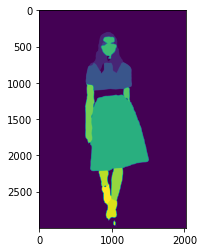

In [39]:
img = cv2.imread("./images/2.jpg")
extract(img, ['Upper-clothes', 'Dress', 'Coat', 'Socks', 'Pants', 'Jumpsuits', 'Scarf', 'Skirt', 'Glove'])